## Imports

In [1]:
import os
import sys
import numpy as np
import time
import scipy
import matplotlib.pyplot as plt
import time
from scipy.stats import binned_statistic

In [2]:
# import the frank2d directory
current_dir =  os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
sys.path.append(parent_dir)

#frank2d
from frank2d import Frank2D
from constants import rad_to_arcsec
from plot import Plot
from fitting import IterativeSolverMethod

# frank1d
import frank
from frank.geometry import FixedGeometry, SourceGeometry, FitGeometryGaussian
from frank.radial_fitters import FrankFitter
from frank.utilities import UVDataBinner

### Functions

In [3]:
def deproject(u, v, inc, PA, inverse=False):
    r"""
    Deproject the image in visibily space

    Parameters
    ----------
    u : array of real, size = N, unit = :math:`\lambda`
        u-points of the visibilities
    v : array of real, size = N, unit = :math:`\lambda`
        v-points of the visibilities
    inc : float, unit = deg
        Inclination
    PA : float, unit = deg
        Position angle, defined east of north.
    inverse : bool, default=False
        If True, the uv-points are reprojected rather than deprojected

    Returns
    -------
    up : array, size = N, unit = :math:`\lambda`
        Deprojected u-points
    vp : array, size = N, unit = :math:`\lambda`
        Deprojected v-points
    wp : array of real, size = N, unit = :math:`\lambda`
        Fourier w-points of the deprojected visibilities. Only returned if
        deprojecting.

    """
    deg_to_rad = np.pi / 180
    inc *= deg_to_rad
    PA *= deg_to_rad

    cos_t = np.cos(PA)
    sin_t = np.sin(PA)

    if inverse:
        sin_t *= -1
        u = u / np.cos(inc)

    up = u * cos_t - v * sin_t
    vp = u * sin_t + v * cos_t

    if inverse:
        return up, vp
    else:
    #   Deproject
        wp = up * np.sin(inc)
        up = up * np.cos(inc)

        return up, vp, wp

In [4]:
 def apply_correction(self, u, v, V, use3D=False):
        r"""
        Correct the phase centre and deproject the visibilities

        Parameters
        ----------
        u : array of real, size = N, unit = :math:`\lambda`
            u-points of the visibilities
        v : array of real, size = N, unit = :math:`\lambda`
            v-points of the visibilities
        V : array of real, size = N, units = Jy
            Complex visibilites
        use3D : bool, default=False
            If True, also return the 3rd compoent of the
            de-projected visibilities, wp.

        Returns
        -------
        up : array of real, size = N, unit = :math:`\lambda`
            Corrected u-points of the visibilities
        vp : array of real, size = N, unit = :math:`\lambda`
            Corrected v-points of the visibilities
        wp : array of real, size = N, unit = :math:`\lambda`
            [Optional] Corrected w-points of the visibilities
        Vp : array of real, size = N, unit = Jy
            Corrected complex visibilites

        """
        Vp = apply_phase_shift(u, v, V, self._dRA, self._dDec, inverse=True)
        up, vp, wp = deproject(u, v, self._inc, self._PA)

        if use3D:
            return up, vp, wp, Vp
        else:
            return up, vp, Vp

In [5]:
def get_radial_profile(frank_object):
    x = frank_object._FT._Xn*rad_to_arcsec
    y = frank_object._FT._Yn*rad_to_arcsec
    pixel_size = (x[1]-x[0])
    r = np.hypot(x, y)
    I = frank_object.sol_intensity
    r = r.flatten()
    I = I.flatten()
    N = frank_object._Nx
    bin = (np.max(r) - np.min(r))/N
    I_binned, bin_edges, _ = binned_statistic(r, I, 'mean', N)
    r_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    return r_centers, I_binned

def get_vis_profile(frank_object):
    u = frank_object._FT._Un
    v = frank_object._FT._Vn
    pixel_size = (u[1]-u[0])
    q = np.hypot(u, v)
    Vis = frank_object.sol_visibility
    q = q.flatten()
    Vis = Vis.flatten()
    N = frank_object._Nx
    bin = (np.max(q) - np.min(q))/N
    weights_gridded = frank_object._gridded_data['weights']
    Vis_binned, bin_edges, _ = binned_statistic(q, Vis, 'mean', N)
    Vis_Weights_binned, bin_edges, _ = binned_statistic(q, Vis*weights_gridded, 'sum', N)
    Weights_binned, bin_edges, _ = binned_statistic(q, weights_gridded, 'sum', N)
    q_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    return q_centers, Vis_Weights_binned/Weights_binned

### Data

In [6]:
# Huang 2018 
inc = 34.97
pa = 85.76
dra = 1.9e-3
ddec = -2.5e-3
Rout = 2 #arcsecs

# UVtable
dir = "../../../data/"
data_file = dir +'AS209_continuum_prom_1chan_30s_keepflagsFalse.txt'

 # load data||
u, v, Re, Imag, Weights = np.loadtxt(data_file, unpack = True)
Vis = Re + Imag*1j

geom = SourceGeometry(inc= inc, PA= pa, dRA= dra, dDec= ddec)
u_deproj, v_deproj, vis_deproj = geom.apply_correction(u, v, Vis)

# Frank2D

In [47]:
N = 300
m, c, lu, lv = -0.33, -0.1, 2e5, 3e5

In [ ]:
start_time = time.time()

#####

frank2d = Frank2D(N, Rout, geometry = [inc, pa, dra, ddec])
frank2d.set_kernel('Wendland', [m, c, lu, lv])
frank2d.fit(u, v, Vis, Weights, method = 'bicgstab', rtol = 1e-15, frank1d_guess = True)

#####
print("--------------------------------------")
end_time = time.time()
execution_time = end_time - start_time
print(f'time = {execution_time/60 :.2f}  min | {execution_time: .2f} seconds')

Setting kernel...Wendland
Gridding...
  --> time = 0.01  min |  0.51 seconds
Setting guess with Frank1D ...
Setting guess...
Setting fit with bicgstab ...
Fitting...
  *  Constructing linear operators...
Setting A...
Setting A_precond...
Setting b...
     --> time = 9.75  min |  584.90 seconds
  *  Solving linear system...
     * BICGSTAB
         * rtol: 1e-15
         * final tolerance: 8.758717475932066e-08
         * maxiter:  900000
             .. iteration:  0
             .. iteration:  1
             .. iteration:  2
             .. iteration:  3
             .. iteration:  4
             .. iteration:  5
             .. iteration:  6
             .. iteration:  7
             .. iteration:  8
             .. iteration:  9
             .. iteration:  10
             .. iteration:  11
             .. iteration:  12
             .. iteration:  13
             .. iteration:  14
             .. iteration:  15
             .. iteration:  16
             .. iteration:  17
          

In [28]:
u_gridded = frank2d._gridded_data['u']
v_gridded = frank2d._gridded_data['v']
vis_gridded = frank2d._gridded_data['vis']

In [29]:
FT = frank2d._FT

In [30]:
vis_sol = frank2d.sol_visibility.reshape(FT._Nx, FT._Ny)
vis_sol.shape

(300, 300)

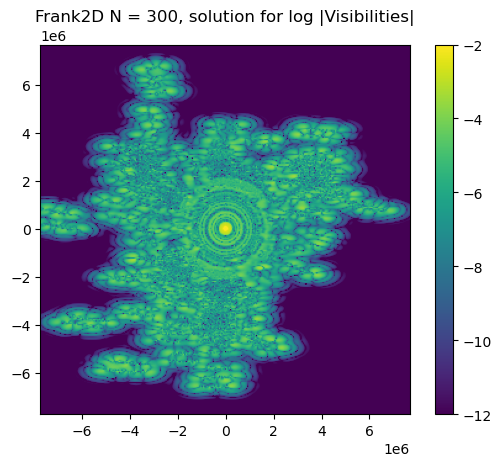

In [31]:
extent=[u_gridded.min(), u_gridded.max(), v_gridded.min(), v_gridded.max()]
plt.imshow(np.log(np.abs(np.fft.fftshift(vis_sol.real.reshape(N, N)))), extent=extent, origin='lower', vmin=-12, vmax=-2)
plt.title(F'Frank2D N = {N}, solution for log |Visibilities|')
plt.colorbar()

/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_71579/2256721134.py:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(np.fft.fftshift(vis_gridded.reshape(N, N)))), extent=extent, origin='lower', vmin=-12, vmax=-2)


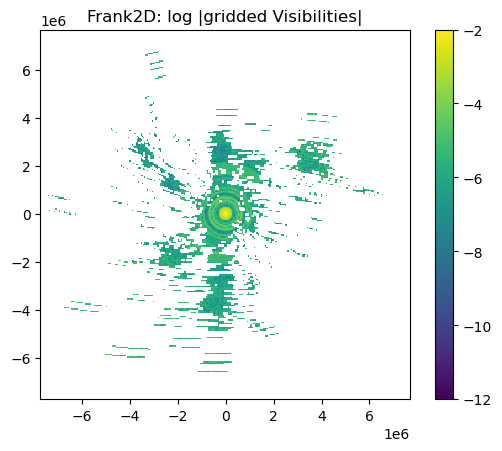

In [16]:
plt.figure()
plt.imshow(np.log(np.abs(np.fft.fftshift(vis_gridded.reshape(N, N)))), extent=extent, origin='lower', vmin=-12, vmax=-2)
plt.title(f'Frank2D: log |gridded Visibilities|')
plt.colorbar()

In [39]:
frank2d.fft()

Inverting with 2fft ...
  --> time = 0.00  min |  0.03 seconds


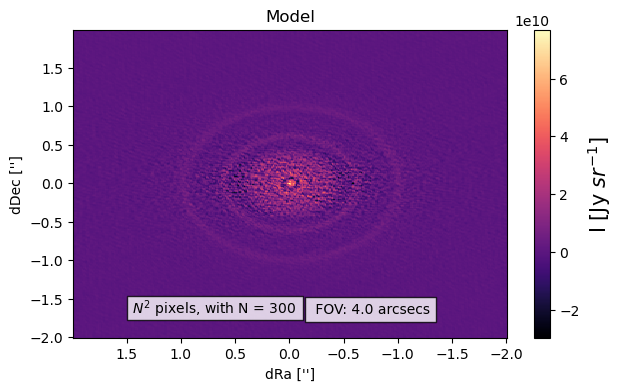

In [40]:
Plot(frank2d).get_image()

In [41]:
r, I = get_radial_profile(frank2d)

In [42]:
# Frank 1D Parameters
n_pts = 300
alpha = 1.3
w_smooth = 1e-1

geom = SourceGeometry(inc= inc, PA= pa, dRA= dra, dDec= ddec)
FF = FrankFitter(Rout, n_pts, geom, alpha = alpha, weights_smooth = w_smooth)
sol = FF.fit(u, v, Vis, Weights)

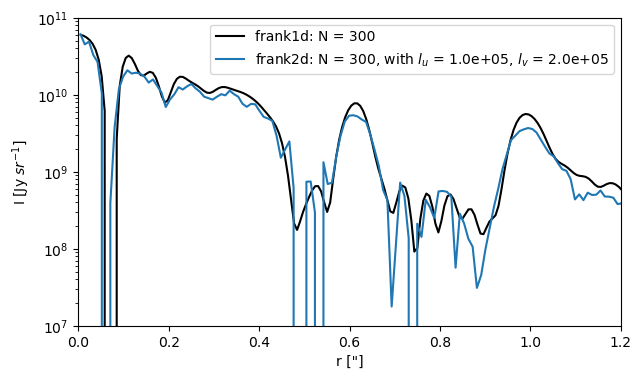

In [46]:
plt.figure(figsize=(7,4))
plt.plot(sol.r, sol.mean, 'black',label =f'frank1d: N = {n_pts}')
plt.plot(r, I, label = f'frank2d: N = {N}, with $l_u$ = {lu:.1e}, $l_v$ = {lv:.1e}')
plt.xlabel('r ["]')
plt.xlim(0, 1.2)      
plt.ylim(1e7, 1e11)
plt.ylabel(r'I [Jy $sr^{-1}$]')
plt.legend()
plt.yscale("log")
plt.show()

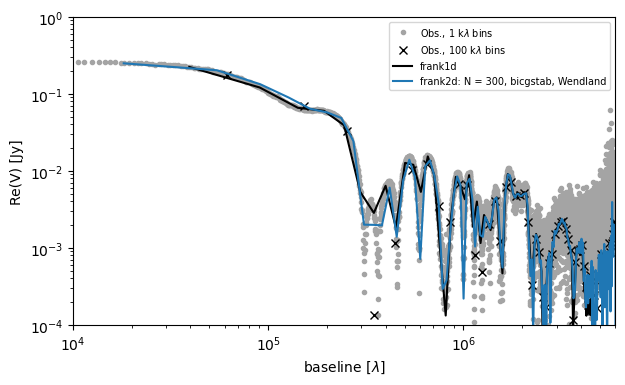

In [56]:
cs, ms = ['#a4a4a4', 'k'], ['.', 'x']
bin_widths=[1e3, 1e5]
baselines = np.hypot(u_deproj, v_deproj)         
grid = np.logspace(np.log10(min(baselines.min(), baselines[0])),
                           np.log10(max(baselines.max(), baselines[-1])),
                           10**4)

plt.figure(figsize=(7,4))

for i in range(len(bin_widths)):
            binned_vis = UVDataBinner(baselines, vis_deproj, Weights, bin_widths[i])
            plt.plot(binned_vis.uv, np.abs(binned_vis.V), c=cs[i],
                         marker=ms[i], ls='None', 
                         label=r'Obs., {:.0f} k$\lambda$ bins'.format(bin_widths[i]/1e3))


#frank1d
vis_fit_1d = sol.predict_deprojected(sol.q)
baselines_fit_1d = sol.q
plt.plot(baselines_fit_1d, np.abs(vis_fit_1d), color = "black", label = r'frank1d')

#frank2d
q, Vis_1= get_vis_profile(frank2d)
plt.plot(q, np.abs(Vis_1.real), label = f'frank2d: N = {N}, bicgstab, Wendland')

plt.xlabel(r'baseline [$\lambda$]')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-4, 1)
plt.xlim(1e4, 6e6)
plt.ylabel('Re(V) [Jy]', size = 10)
plt.legend(fontsize =7)
plt.show()

### Comparing with CLEAN

In [311]:
# Obtain the radial profiles convolved to a circular beam.
from gofish import imagecube

infile_1mm = dir + 'AS209_1mm_13s_conv_circ.fits'
#2D->1D
cube_1mm = imagecube(infile_1mm)
x_1mm,y_1mm,dy_1mm = cube_1mm.radial_profile(inc=inc, PA=pa, x0=dra, y0=ddec)

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


In [312]:
from frank.utilities import convolve_profile

clean_beam_1mm = {'bmaj':0.0373, 'bmin':0.0373, 'beam_pa':31.040}
area_1mm = clean_beam_1mm['bmaj']*clean_beam_1mm['bmin']*np.pi/4./np.log(2.)*(1/rad_to_arcsec)**2

convolved_1mm_frank2d = convolve_profile(r, I, inc, pa, clean_beam_1mm)*area_1mm
convolved_1mm_frank1d = convolve_profile(sol.r, sol.mean, inc, pa, clean_beam_1mm)*area_1mm

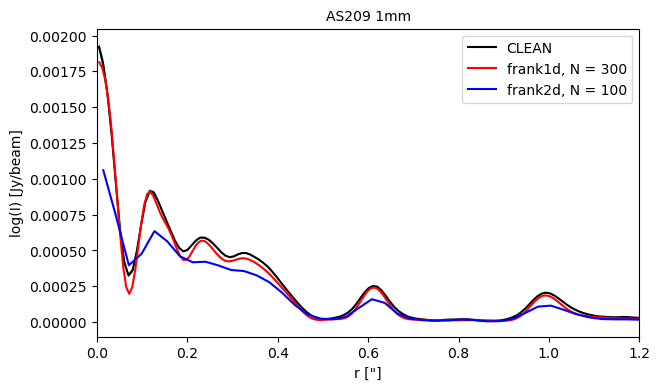

In [313]:
plt.figure(figsize=(7, 4))
plt.plot(x_1mm, y_1mm, "black", label = "CLEAN")
plt.fill_between(x_1mm, y_1mm-dy_1mm, y_1mm+dy_1mm,alpha=0.7)
plt.plot(sol.r, convolved_1mm_frank1d, "red", label=r'frank1d' + ', N = ' +str(n_pts))
plt.plot(r,convolved_1mm_frank2d, "blue", label=r'frank2d' + ', N = ' +str(N))
plt.title(r'AS209 1mm', size=10)
plt.ylabel("log(I) [Jy/beam]", size=10)
plt.xlabel('r ["]', size=10)
plt.legend(fontsize=10)
#plt.yscale('log')
#plt.ylim(0.1e-5, 0.5e-2)
plt.xlim(0,1.2)
plt.show()